Project: # Patil_ADEarlyDetection

# **Phase 2:**  
## CNN with TL = DenseNet201

## **Exp 10**
### Densenet201 
### Matrix =auc
### acc monitor =val_acc 
### LR=0.0001 
### EPOCH 200 (EarlyStp=30)
### CategoricalAccuracy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/AD_proj"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Alzheimer_s_Dataset	proj_ADEarlyDetection_densenet201_exp6.ipynb
desnsenet_single_label	proj_ADEarlyDetection_densenet201_rev2.ipynb
my_best_models


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, save_model
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, GaussianNoise
from keras.metrics import AUC, Accuracy, CategoricalAccuracy
from keras.optimizers import Adam
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.applications.densenet import DenseNet201
from keras.callbacks import EarlyStopping, ModelCheckpoint


import numpy as np
import IPython
import itertools

# Plot libs
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import sys
sys.path.append('/content/drive/My Drive/AD_proj')

#
# Define constants
#
NUM_EPOCH = 200 #200
NUM_PATIENCE = 30 #30
NUM_VAL_SPLIT = 0.2
NUM_IMG_RESCALE = 1/255
NUM_BATCH_SIZE = 128
NUM_IMAGE_SIZE = 224
NUM_LEARNING_RATE = 0.0001
ad_model_filename = "/content/drive/My Drive/AD_proj/my_best_models/densenet201_exp10.hdf5"

target_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
# Data augmentation to avoid overfitting
#train = ImageDataGenerator(validation_split=NUM_VAL_SPLIT,
#                           rotation_range=40,
#                           zoom_range=0.2,
#                           horizontal_flip=True, 
#                           vertical_flip=True, 
#                           rescale=NUM_IMG_RESCALE)

train = ImageDataGenerator(validation_split=NUM_VAL_SPLIT, rescale=NUM_IMG_RESCALE)
validation = ImageDataGenerator(validation_split=NUM_VAL_SPLIT, rescale=NUM_IMG_RESCALE)

test = ImageDataGenerator(rescale=NUM_IMG_RESCALE)

train_dataset = train.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='training')
val_dataset = validation.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='validation')

test_dataset = test.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/test', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical')

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
#--------------------------------------------------------------------
# Function Name: f_ad_model_builder
# Description: Build Convolutional Neural Network (CNN) Deep learning model
#              for early diagnosis of Alzheimer's disease
# Output : 4 output classes 

# Activation function RELU:
# The rectified linear activation function or ReLU for short is a piecewise 
# linear function that will output the input directly if it is positive, 
# otherwise, it will output zero. It has become the default activation function 
# for many types of neural networks because a model that uses it is easier to train 
# and often achieves better performance.
#
#--------------------------------------------------------------------
def f_ad_model_builder():
    
  # 
  # Keras Model Instantiation
  # From https://keras.io/api/applications/: Keras Applications are deep learning models that are 
  # made available alongside pre-trained weights. Weights are downloaded automatically when instantiating a model.
  # It is also known as Transfer layer model
  #model_TL = DenseNet169(input_shape=(NUM_IMAGE_SIZE,NUM_IMAGE_SIZE,3), include_top=False, weights="imagenet")
  model_TL = DenseNet201(input_shape=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE, 3), include_top=False, weights="imagenet")

  #print('----------- Transfer Layer ---------\n')
  #model_densenet201.summary()
  #print('------------------------------------\n')

  # freeze layers
  for layer in model_TL.layers :
    layer.trainable = False

  # Kera Sequential model is appropriate for deep neural networks
  model = Sequential()
  model.add(model_TL)

  # Dropout is a regularization technique that prevents neural networks from overfitting
  # It modify the network itself. It randomly drops neurons from the neural network 
  # during training in each iteration.
  model.add(Dropout(0.5)) # dropout few nodes to prevent overfitting

  model.add(Flatten()) 

  model.add(BatchNormalization()) # standardize input to next layer

  # Dense later #1
  model.add(Dense(2048,kernel_initializer='he_uniform'))
  
  model.add(BatchNormalization()) # standardize input to next layer 
  model.add(GaussianNoise(0.1))
  model.add(Activation('relu'))
  model.add(Dropout(0.5)) # dropout few nodes to prevent overfitting

  # Dense later #2
  model.add(Dense(1024,kernel_initializer='he_uniform'))

  model.add(BatchNormalization()) # standardize input to next layer
  model.add(GaussianNoise(0.1))
  model.add(Activation('relu'))
  model.add(Dropout(0.5)) # dropout few nodes to prevent overfitting

  # Dense later #3 (Outout)
  model.add(Dense(4,activation='softmax'))

  model.summary()

  #
  # COMPILE: Tune the learning rate for the optimizer value choice 
  # from 0.01, 0.001, or 0.0001
  # 
  model.compile(optimizer = Adam(learning_rate = NUM_LEARNING_RATE),
                loss = 'categorical_crossentropy', 
                metrics = [AUC(name = 'auc', multi_label=True), CategoricalAccuracy(name = 'accuracy')])

  # metrics=['mae', 'acc']
  
  return model

#--------------------------------------------------------------------
# Function Name: f_ad_plot_auc_loss
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_plot_auc_loss(f_model):

  # create subplots
  fig, axs = plt.subplots(1,3,figsize=(15,10))

  ticks = np.arange(1,len(f_model.history['loss'])+1)
  history_acc_length = len(f_model.history['accuracy'])+1
  history_val_acc_length = len(f_model.history['val_accuracy'])+1
  history_auc_length = len(f_model.history['auc'])+1
  history_val_auc_length = len(f_model.history['val_auc'])+1
  history_loss_length = len(f_model.history['loss'])+1
  history_val_loss_length = len(f_model.history['val_loss'])+1

  # Summarize history for ACC
  axs[0].plot(range(1,history_acc_length), f_model.history['accuracy'])
  axs[0].plot(range(1,history_val_acc_length), f_model.history['val_accuracy'])
  axs[0].set_title('MODEL ACCURACY')
  axs[0].set_ylabel('ACC')
  axs[0].set_xlabel('Epoch')
  axs[0].set_xticks(ticks,len(f_model.history['accuracy'])/10)
  axs[0].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

  # Summarize history for AUC
  axs[1].plot(range(1,history_auc_length), f_model.history['auc'])
  axs[1].plot(range(1,history_val_auc_length), f_model.history['val_auc'])
  axs[1].set_title('Model Area Under Curve - AUC')
  axs[1].set_ylabel('AUC')
  axs[1].set_xlabel('Epoch')
  axs[1].set_xticks(ticks,len(f_model.history['auc'])/10)
  axs[1].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

  # Summarize history for loss
  axs[2].plot(range(1, history_loss_length), f_model.history['loss'])
  axs[2].plot(range(1,history_val_loss_length), f_model.history['val_loss'])
  axs[2].set_title('Model Loss')
  axs[2].set_ylabel('Loss')
  axs[2].set_xlabel('Epoch')
  axs[2].set_xticks(ticks,len(f_model.history['loss'])/10)
  axs[2].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

#--------------------------------------------------------------------
# Function Name: plot_confusion_matrix
# Description: 
# source code from : scikit-learn.org
#--------------------------------------------------------------------
def f_ad_plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 1920)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 94080)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 94080)             376320    
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              192677888 
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
gaussian_noise (GaussianNois (None, 2048)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


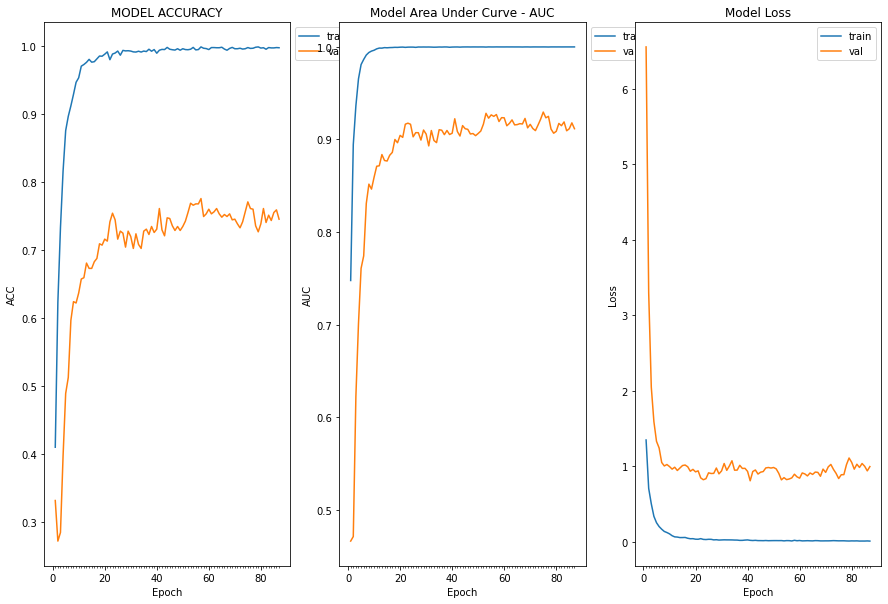

In [ ]:
checkpoint = ModelCheckpoint(ad_model_filename, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=NUM_PATIENCE, verbose=1, mode='max') 

model = f_ad_model_builder()

class_weights = compute_class_weight('balanced', np.unique(test_dataset.classes), np.array(test_dataset.classes))
d_class_weights = dict(enumerate(class_weights))

model_history = model.fit(train_dataset,
                        validation_data = val_dataset,
                        epochs = NUM_EPOCH,
                        class_weight = d_class_weights,
                        callbacks = [checkpoint, early])

print('--------------------------------------------\n')
print('Results:')
f_ad_plot_auc_loss(model_history)

#!ls -al '/content/drive/My Drive/AD_proj/my_best_models'


Evaluate on test data
10/10 [==============================] - 11s 573ms/step - loss: 1.1445 - auc: 0.8858 - accuracy: 0.7435
test loss, test auc test accuracy: [1.1445026397705078, 0.8858437538146973, 0.743549644947052]
-----------------------------------------------------
Classification Report [test DataSet]
                  precision    recall  f1-score   support

    MildDemented       0.11      0.07      0.08       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.51      0.59      0.55       640
VeryMildDemented       0.35      0.33      0.34       448

        accuracy                           0.42      1279
       macro avg       0.24      0.25      0.24      1279
    weighted avg       0.39      0.42      0.40      1279

-----------------------------------------------------
Confusion matrix, without normalization
[[ 12   1 101  65]
 [  2   0   7   3]
 [ 50   5 376 209]
 [ 46   5 249 148]]


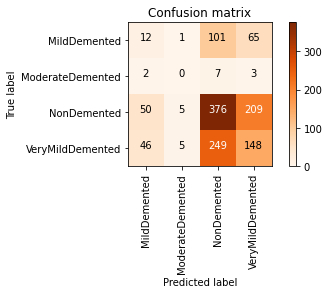

In [ ]:
#
# load model
#
loaded_model = load_model(filepath=ad_model_filename)

print("Evaluate on test data")
test_results = loaded_model.evaluate(test_dataset, batch_size=NUM_BATCH_SIZE)
print("test loss, test auc test accuracy:", test_results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
test_pred = loaded_model.predict(test_dataset)
test_pred_classes = np.argmax(test_pred, axis=1)

#print ('-----------------------------------------------------')
#print('Confusion Matrix [test DataSet]')
cm = confusion_matrix(test_dataset.classes, test_pred_classes)

print ('-----------------------------------------------------')
print('Classification Report [test DataSet]')
print(classification_report(test_dataset.classes, test_pred_classes, target_names=target_names))

print ('-----------------------------------------------------')
#plot the matrix
f_ad_plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges)